## Imports

In [ ]:
import matplotlib
import numpy as np
matplotlib.use("Agg")  # Utilisation du backend non-interactif pour éviter les erreurs
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
from google.colab import drive
drive.mount('dirve_path')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Paramètres

In [ ]:
DATASET_PATH = "dataset_path" # à adapter pour récupérer le dataset via un drive/dossier local/kaggle

IMG_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 15

TRAIN_DIR = os.path.join(DATASET_PATH, "train")
VAL_DIR = os.path.join(DATASET_PATH, "val")
TEST_DIR = os.path.join(DATASET_PATH, "test")


## 2. Préparation des générateurs (sans augmentation)

In [ ]:
plain_datagen = ImageDataGenerator(rescale=1./255)

train_gen = plain_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = plain_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_gen = plain_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

## 3. Création du modèle CNN

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

## 4. Entraînement

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 139s 342ms/step - accuracy: 0.4504 - loss: 1.4350 - val_accuracy: 0.8969 - val_loss: 0.3498
Epoch 2/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 132s 350ms/step - accuracy: 0.8409 - loss: 0.4565 - val_accuracy: 0.9631 - val_loss: 0.1495
Epoch 3/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 136s 334ms/step - accuracy: 0.8975 - loss: 0.2918 - val_accuracy: 0.9716 - val_loss: 0.1033
Epoch 4/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 139s 326ms/step - accuracy: 0.9294 - loss: 0.1977 - val_accuracy: 0.9783 - val_loss: 0.0795
Epoch 5/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 143s 328ms/step - accuracy: 0.9409 - loss: 0.1598 - val_accuracy: 0.9811 - val_loss: 0.0645
Epoch 6/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 124s 329ms/step - accuracy: 0.9522 - loss: 0.1316 - val_accuracy: 0.9861 - val_loss: 0.0544
Epoch 7/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 145s 335ms/step - accuracy: 0.9607 - loss: 0.1109 - val_accuracy: 0.9833 - val_loss: 0.0576
Epoch 8/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 122s 325ms/step - accuracy: 0.9636 -

## 5. Évaluation sur test

In [ ]:
test_loss, test_acc = model.evaluate(test_gen)
print("\nTest Accuracy :", test_acc)

128/128 ━━━━━━━━━━━━━━━━━━━━ 1437s 11s/step - accuracy: 0.9905 - loss: 0.0388

Test Accuracy : 0.9907135963439941


## 6. Courbes d'apprentissage sauvegardées

In [ ]:
from IPython.display import Image, display
fig1 = plt.figure()
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
fig1.savefig("accuracy.png")


fig2 = plt.figure()
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
fig2.savefig("loss.png")

display(Image(filename="accuracy.png"))
display(Image(filename="loss.png"))

NameError: name 'plt' is not defined

## 7. Matrice de coût et accuracy pondérée

In [ ]:
from sklearn.metrics import confusion_matrix

y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Assure-toi que ce mapping correspond bien à l'ordre des classes
label_map = test_gen.class_indices
inverse_label_map = {v: k for k, v in label_map.items()}
class_names = [inverse_label_map[i] for i in range(len(inverse_label_map))]

cost_dict = {
    'circle':         [0, 7, 8, 8, 8, 8, 6, 9],
    'kite':           [7, 0, 4, 5, 3, 4, 5, 6],
    'parallelogram':  [8, 4, 0, 2, 3, 2, 3, 7],
    'rectangle':      [8, 5, 2, 0, 3, 1, 3, 6],
    'rhombus':        [8, 3, 3, 3, 0, 1, 4, 6],
    'square':         [8, 4, 2, 1, 1, 0, 3, 6],
    'trapezoid':      [6, 5, 3, 3, 4, 3, 0, 5],
    'triangle':       [9, 6, 7, 6, 6, 6, 5, 0],
}

cost_matrix = np.array([cost_dict[cls] for cls in class_names])

cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
weighted_error = np.sum(cm * cost_matrix)
max_possible_error = np.sum(cm) * np.max(cost_matrix)
weighted_acc = 1 - (weighted_error / max_possible_error)

print(f"\n Accuracy pondérée (avec matrice de coûts) : {weighted_acc:.4f}")

128/128 ━━━━━━━━━━━━━━━━━━━━ 26s 203ms/step

🎯 Accuracy pondérée (avec matrice de coûts) : 0.9942


## 8. Matrice de confusion

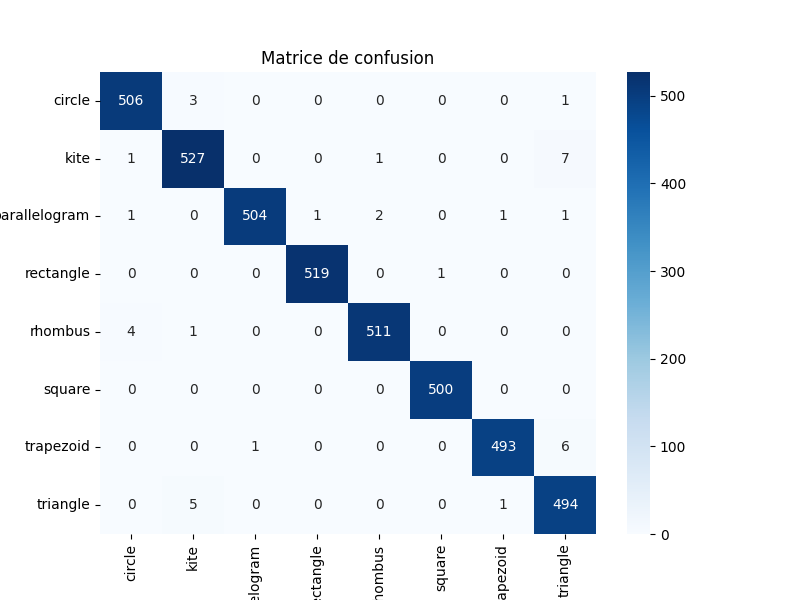

In [ ]:
import seaborn as sns


fig3 = plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prédictions')
plt.ylabel('Vrais labels')
plt.title('Matrice de confusion')
fig3.savefig("confmat.png")
display(Image(filename="confmat.png"))
